# Explore Quantum Index Report Full Dataset

In [62]:
#imports

import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib.font_manager import FontProperties

#import quantile regression 
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
import re
import math



In [42]:

# read in QPU metris from QPUmetric.csv
# read in QPU metrics from QPUmetric.csv
#print hello world




# read in QPU metrics from QPUmetric.csv
csvfile = 'Datasets/QPUmetrics.csv'
# qpu_metrics = pd.read_csv(csvfile)
#forget the first row
qpu_metrics = pd.read_csv(csvfile, skiprows=1)

print(qpu_metrics['w'])
#view dataframe
# qpu_metrics


#only select superconducting qpus ie where modality is superconducting
# print(qpu_metrics.columns)
superconducting_qpus = qpu_metrics[qpu_metrics['Modality'] == 'Superconducting']
# print(superconducting_qpus)
#filter out any qpus with dates either not available or past 2024
superconducting_qpus = superconducting_qpus[superconducting_qpus['w'].notna()]
# print(superconducting_qpus)
superconducting_qpus.dropna(subset=['Qubits/ Qumodes', 'w'], inplace=True)
#removing any QPUs where is comercially available is Future plan
superconducting_qpus = superconducting_qpus[superconducting_qpus['Commercially available?'] != 'Future Plan']
# Remove commas from 'Qubits/ Qumodes' and convert to integer
superconducting_qpus['Qubits/ Qumodes'] = superconducting_qpus['Qubits/ Qumodes'].str.replace(',', '').astype(int)
#make the w column an integer
superconducting_qpus['w'] = superconducting_qpus['w'].astype(int)
superconducting_qpus = superconducting_qpus[superconducting_qpus['w'] <= 2024]
# print(superconducting_qpus['Qubits/ Qumodes'])




0       NaN
1      2018
2      2022
3      2024
4      2024
       ... 
237    2020
238    2024
239    2026
240     NaN
241     NaN
Name: w, Length: 242, dtype: object


Number of qubits for each model at the year 2025
80th percentile: 127.92030015832412
50th percentile: 87.60429271447327
90th percentile: 305.1362354146422
IBM projection: 190

Projected number of qubits in 2030:
80th percentile projection: 129
50th percentile projection: 234
90th percentile projection: 1315
IBM projection: 962


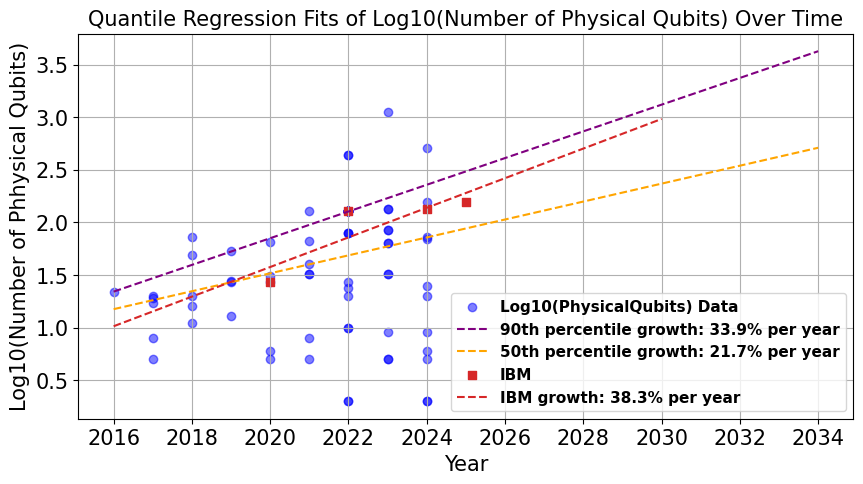

In [43]:

#+====================================================================

#dealing wit max fit
superconducting_qpus = superconducting_qpus.sort_values(by='w')

# Select only the maximum qubit points
max_qubits = -1
max_points = []

for _, row in superconducting_qpus.iterrows():
    if row['Qubits/ Qumodes'] > max_qubits:
        max_qubits = row['Qubits/ Qumodes']
        max_points.append(row)

max_points = pd.DataFrame(max_points)

# Define a linear model for fitting (since y = log10(qubits))
def linear_model(x, a, b):
    return a * x + b

# Extract x (year) and y (log10 of qubits) data for fitting
x_data = max_points['w']  # Year
y_data = np.log10(max_points['Qubits/ Qumodes'])  # Log10 of number of qubits

#print the tuple of this data
# print(list(zip(x_data, 10**y_data)))


# Perform linear fitting
params, covariance = curve_fit(linear_model, x_data, y_data)

# Generate fit line
x_fit = np.linspace(x_data.min(), 2034, 100)

y_fit = linear_model(x_fit, *params)


# print(superconducting_qpus)

# #now I want to plot the number of qubits against the year for entries that have number ofqubits available


#make a fit of just the data points where the number of qubits is greater than the number of qubits that have come before
#do a quantile fit on the top 20% of qubits

# Perform quantile regression on the top 20th percentile and median of qubits
y_data = np.log10(superconducting_qpus['Qubits/ Qumodes'])
x_data = superconducting_qpus['w']
model = QuantReg(y_data, sm.add_constant(x_data))

# Fit 95th percentile
res_90 = model.fit(q=0.8)
slope_q90 = res_90.params["w"]
intercept_q90 = res_90.params["const"]

# Fit 80th percentile
res_80 = model.fit(q=0.9)
slope_q80 = res_80.params["w"]
intercept_q80 = res_80.params["const"]

# Fit 50th percentile (median)
res_50 = model.fit(q=0.5)
slope_q50 = res_50.params["w"]
intercept_q50 = res_50.params["const"]

x_fit = np.linspace(x_data.min(), 2034, 100)
# Generate fit lines for quantile regressions
def linear_model(x, a, b):
    return a * x + b
y_quantile_fit_90 = linear_model(x_fit, slope_q90, intercept_q90)
# y_quantile_fit_80 = linear_model(x_fit, slope_q80, intercept_q80)
y_quantile_fit_50 = linear_model(x_fit, slope_q50, intercept_q50)

# Calculate yearly growth rates
# growth_rate_95 = (10**(slope_q95) - 1) * 100
growth_rate_90 = (10**(slope_q90)-1)*100
growth_rate_80 = (10**(slope_q80) - 1) * 100
growth_rate_50 = (10**(slope_q50) - 1) * 100
growth_rate_max = (10**(params[0]) - 1) * 100

# Plot the data points, linear fit, and quantile regression fits
plt.figure(figsize=(10, 5))
plt.scatter(superconducting_qpus['w'], np.log10(superconducting_qpus['Qubits/ Qumodes']), label='Log10(PhysicalQubits) Data', color='blue', alpha=0.5)
plt.plot(x_fit, y_quantile_fit_90, color='purple', linestyle='--', label=f'90th percentile growth: {growth_rate_90:.1f}% per year')

# plt.plot(x_fit, y_quantile_fit_80, color='green', linestyle='--', label=f'80th percentile growth: {growth_rate_80:.1f}% per year')
plt.plot(x_fit, y_quantile_fit_50, color='orange', linestyle='--', label=f'50th percentile growth: {growth_rate_50:.1f}% per year')
# plt.plot(x_fit, y_fit, color='red', label=f'Maximum growth: {growth_rate_max:.1f}% per year')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Log10(Number of Phhysical Qubits)', fontsize=15)
plt.title('Quantile Regression Fits of Log10(Number of Physical Qubits) Over Time', fontsize=15)

#plot the IBM roadmap
IBM_points = [(2020, 27), (2022, 127), (2024, 133), (2025,156)]
IBM_points = pd.DataFrame(IBM_points, columns=['w', 'Qubits/ Qumodes'])
plt.scatter(IBM_points['w'], np.log10(IBM_points['Qubits/ Qumodes']), label='IBM', color='tab:red', marker='s')

# Add trend line for IBM points
IBM_x_data = IBM_points['w']
IBM_y_data = np.log10(IBM_points['Qubits/ Qumodes'])
IBM_params, IBM_covariance = curve_fit(linear_model, IBM_x_data, IBM_y_data)
IBM_x_fit = np.linspace(x_data.min(), 2030, 50)
IBM_y_fit = linear_model(IBM_x_fit, *IBM_params)
IBM_growth_rate = (10**(IBM_params[0]) - 1) * 100
plt.plot(IBM_x_fit, IBM_y_fit, color='tab:red', linestyle='--', label=f'IBM growth: {IBM_growth_rate:.1f}% per year')

# Set x-axis ticks to whole numbers
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))


#print me the number of qubits for each model at the year 2025  
print("Number of qubits for each model at the year 2025")
# print(f"95th percentile: {10**(slope_q95*2025 + intercept_q95)}")
print(f"80th percentile: {10**(slope_q80*2025 + intercept_q80)}")
print(f"50th percentile: {10**(slope_q50*2025 + intercept_q50)}")
print(f"90th percentile: {10**(slope_q90*2025 + intercept_q90)}")
print(f"IBM projection: {10**(IBM_params[0]*2025 + IBM_params[1]):.0f}")
# print(f"Maximum growth: {10**(params[0]*2025 + params[1])}")

# Print projected values for 2030
print("\nProjected number of qubits in 2030:")
# print(f"95th percentile projection: {10**(slope_q95*2030 + intercept_q95):.0f}")
print(f"80th percentile projection: {10**(slope_q80*2030 + intercept_q80):.0f}")
print(f"50th percentile projection: {10**(slope_q50*2030 + intercept_q50):.0f}")
print(f"90th percentile projection: {10**(slope_q90*2030 + intercept_q90):.0f}")
print(f"IBM projection: {10**(IBM_params[0]*2030 + IBM_params[1]):.0f}")
# print(f"Maximum growth projection: {10**(params[0]*2030 + params[1]):.0f}")



plt.legend(prop={'weight': 'bold', 'size': 11}, loc='lower right')
plt.grid()
plt.savefig("figures/overall_qubit_trend.png")
plt.show()
#print hello world using python righ here





# Trend in Generalized Logical Qubits 

72 86730.24200625929
2 13545.031006052604
127 157717.0425499768
127 308357.9247271201
127 562213.5164308747
127 340353.4923073717
127 672474.5802650158
127 248099200.19980538
127 308657.17552650574
127 173199.35850161724
133 15878.389046108923
5 1009240.7753442281
9 459743.90523412643
5 15184.226409982679
156 14851.611624418663
20 44115.9512705241
[ 1.79829894e-01 -3.66128717e+02]

Projected logical qubits in 2025 using the fit: 0.0106


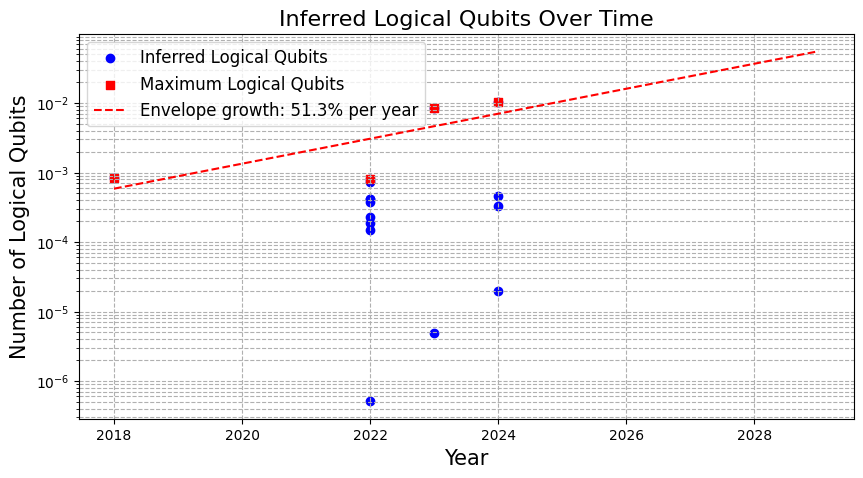

In [44]:
def surface_code_formula(pP: float) -> float:
    try:
        pL = 1e-18
        pth = 1e-2
        numerator = 4 * math.log(10**0.5 * pP / pL)
        denominator = math.log(pth / pP)
        fraction = numerator / denominator
        f_QEC = (fraction + 1) ** -2  # correction for small pP
        return max(1, f_QEC**-1)
    except (ValueError, ZeroDivisionError, OverflowError) as e:
        # print(f"Error in surface_code_formula with pP={pP}: {e}")
        return float("inf")  # Return infinity for invalid inputs


# filter superconducting qpus for ones that have error rate lower than 1e-2
superconducting_qpus_logical = superconducting_qpus.copy()
superconducting_qpus_logical = superconducting_qpus_logical[
    superconducting_qpus_logical["2-Gate Fidelity (Median/Avg)"].notna()
]

# Check if the column contains string values or numeric values
if superconducting_qpus_logical["2-Gate Fidelity (Median/Avg)"].dtype == "object":
    # If strings with percentage, convert them
    superconducting_qpus_logical["2-Gate Fidelity (Median/Avg)"] = (
        superconducting_qpus_logical["2-Gate Fidelity (Median/Avg)"]
        .str.rstrip("%")
        .astype(float)
        / 100
    )
else:
    # If already numeric, just ensure it's in decimal form (not percentage)
    if superconducting_qpus_logical["2-Gate Fidelity (Median/Avg)"].max() > 1:
        superconducting_qpus_logical["2-Gate Fidelity (Median/Avg)"] = (
            superconducting_qpus_logical["2-Gate Fidelity (Median/Avg)"] / 100
        )

# Calculate error rate (1 - fidelity) and filter for error rate lower than 1e-2
error_rates = 1 - superconducting_qpus_logical["2-Gate Fidelity (Median/Avg)"]
superconducting_qpus_logical = superconducting_qpus_logical[error_rates < 1e-2]

# Apply the surface_code_formula to each error rate individually
logical_qubits = []
for idx, row in superconducting_qpus_logical.iterrows():
    error_rate = 1 - row["2-Gate Fidelity (Median/Avg)"]
    physical_qubits = row["Qubits/ Qumodes"]
    print(row["Qubits/ Qumodes"], surface_code_formula(error_rate))
    logical_qubits_count = physical_qubits / surface_code_formula(error_rate)
    logical_qubits.append(logical_qubits_count)

superconducting_qpus_logical["Inferred_Logical_Qubits"] = logical_qubits

# Find the envelope (maximum logical qubits for each year)
max_logical_qubits = []
years = sorted(superconducting_qpus_logical["w"].unique())
for year in years:
    year_data = superconducting_qpus_logical[superconducting_qpus_logical["w"] == year]
    if not year_data.empty:
        max_value = year_data["Inferred_Logical_Qubits"].max()
        max_logical_qubits.append((year, max_value))

envelope_df = pd.DataFrame(max_logical_qubits, columns=["Year", "Max_Logical_Qubits"])

# plot inferred logical qubits over time
plt.figure(figsize=(10, 5))
plt.scatter(
    superconducting_qpus_logical["w"],
    superconducting_qpus_logical["Inferred_Logical_Qubits"],
    label="Inferred Logical Qubits",
    color="blue",
)

# Plot the envelope points
plt.scatter(
    envelope_df["Year"],
    envelope_df["Max_Logical_Qubits"],
    color="red",
    marker="s",
    label="Maximum Logical Qubits",
)

# Fit a trend line to the envelope points
if len(envelope_df) > 1:
    x_env = envelope_df["Year"]
    y_env = np.log10(envelope_df["Max_Logical_Qubits"])

    # Perform linear fitting on log scale
    env_params, env_covariance = curve_fit(linear_model, x_env, y_env)

    # Create fitted line
    x_fit = np.linspace(x_env.min(), x_env.max() + 5, 50)
    y_fit = linear_model(x_fit, *env_params)

    # Calculate growth rate
    env_growth_rate = (10 ** (env_params[0]) - 1) * 100

    # Plot the fit
    plt.plot(
        x_fit,
        10**y_fit,
        color="red",
        linestyle="--",
        label=f"Envelope growth: {env_growth_rate:.1f}% per year",
    )

plt.xlabel("Year", fontsize=15)
plt.ylabel("Number of Logical Qubits", fontsize=15)
plt.title("Inferred Logical Qubits Over Time", fontsize=16)
plt.yscale("log")
plt.grid(True, which="both", ls="--")
plt.legend(fontsize=12)
print(env_params)

# Print the number of qubits at year 2025 using the fit
projected_2025 = 10**(linear_model(2025, *env_params))
print(f"\nProjected logical qubits in 2025 using the fit: {projected_2025:.4f}")


# Checking Qubit Growth Rates

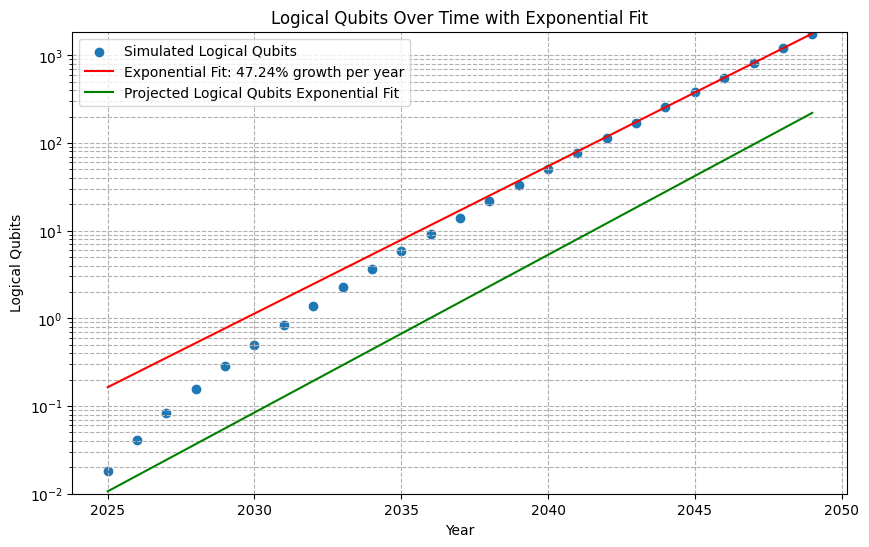

Exponential growth rate: 47.24% per year
Initial value (a): 0.16
Exponential coefficient (b): 0.3869


In [45]:
# trend in logical qubits taking into account the change in logical to physical qubit ratio
initial_error = 10 ** (-2.5)
fidelity_improvement_rate = 0.28
num_years = 25
start_year = 2025
years = np.array([start_year + i for i in range(num_years)])
phyiscal_qubits = np.array([305.13*(1.339)**i for i in range(num_years)])
physical_logical_ratio = np.array([surface_code_formula(initial_error * (1-fidelity_improvement_rate)**i) for i in range(num_years)])
logical_qubits = phyiscal_qubits / physical_logical_ratio
projected_logical_qubits = 10**(linear_model(years, *env_params))
# Fit an exponential model to the logical qubits data
# Define the exponential model: y = a * exp(b * x)
def exp_model(x, a, b):
    return a * np.exp(b * (x - start_year))

# Fit the model to our data
params, covariance = curve_fit(exp_model, years, logical_qubits)

# Extract parameters
a, b = params
annual_growth_rate = (np.exp(b) - 1) * 100  # Convert to percentage

# Generate fitted curve for plotting
y_fit = exp_model(years, a, b)

# Plot the data and the fit
plt.figure(figsize=(10, 6))
plt.scatter(years, logical_qubits, label='Simulated Logical Qubits')

plt.plot(years, y_fit, 'r-', label=f'Exponential Fit: {annual_growth_rate:.2f}% growth per year')
plt.plot(years, projected_logical_qubits, 'g-', label=f'Projected Logical Qubits Exponential Fit')
plt.xlabel('Year')
plt.ylabel('Logical Qubits')
plt.title('Logical Qubits Over Time with Exponential Fit')
plt.ylim(1e-2)
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

print(f"Exponential growth rate: {annual_growth_rate:.2f}% per year")
print(f"Initial value (a): {a:.2f}")
print(f"Exponential coefficient (b): {b:.4f}")


0           NaN
1           NaN
2     -2.552842
3     -1.795880
4     -1.356547
         ...   
237         NaN
238         NaN
239         NaN
240         NaN
241         NaN
Name: 2-Gate Fidelity (log), Length: 242, dtype: float64
[(2017, 5.000000000000001), (2018, 72.00000000000001), (2022, 126.99999999999999), (2023, 133.0), (2024, 156.0)]


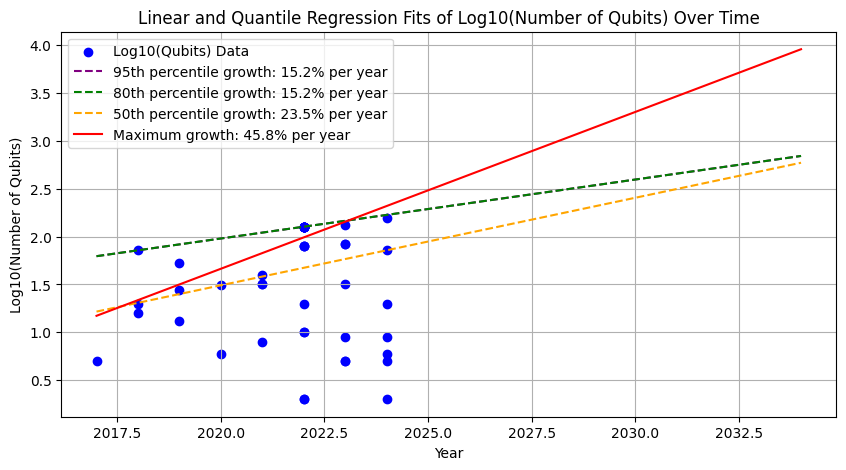

Number of qubits for each model at the year 2025
95th percentile: 194.38241462049834
80th percentile: 194.38209585533977
50th percentile: 88.88428799503995
Maximum growth: 304.57835845167267

Projected number of qubits in 2030:
95th percentile projection: 395
80th percentile projection: 395
50th percentile projection: 255
Maximum growth projection: 2009


In [46]:

#+====================================================================


min_error = 0.0001
max_error = 0.1
#dealing wit max fit
superconducting_qpus = superconducting_qpus.sort_values(by='w')

#control for error 
superconducting_qpus['2-Gate Fidelity (Median/Avg)'] = superconducting_qpus['2-Gate Fidelity (Median/Avg)'].str.rstrip('%').astype(float) / 100

print(qpu_metrics['2-Gate Fidelity (log)'])


error_rates = 1 - superconducting_qpus['2-Gate Fidelity (Median/Avg)']

mask = (error_rates >= min_error) & (error_rates <= max_error)
superconducting_qpus = superconducting_qpus[mask]


# Select only the maximum qubit points
max_qubits = -1
max_points = []

for _, row in superconducting_qpus.iterrows():
    if row['Qubits/ Qumodes'] > max_qubits:
        max_qubits = row['Qubits/ Qumodes']
        max_points.append(row)

max_points = pd.DataFrame(max_points)

# Define a linear model for fitting (since y = log10(qubits))
def linear_model(x, a, b):
    return a * x + b

# Extract x (year) and y (log10 of qubits) data for fitting
x_data = max_points['w']  # Year
y_data = np.log10(max_points['Qubits/ Qumodes'])  # Log10 of number of qubits

#print the tuple of this data
print(list(zip(x_data, 10**y_data)))


# Perform linear fitting
params, covariance = curve_fit(linear_model, x_data, y_data)

# Generate fit line
x_fit = np.linspace(x_data.min(), 2034, 100)

y_fit = linear_model(x_fit, *params)


# print(superconducting_qpus)

# #now I want to plot the number of qubits against the year for entries that have number ofqubits available


#make a fit of just the data points where the number of qubits is greater than the number of qubits that have come before
#do a quantile fit on the top 20% of qubits

# Perform quantile regression on the top 20th percentile and median of qubits
y_data = np.log10(superconducting_qpus['Qubits/ Qumodes'])
x_data = superconducting_qpus['w']
model = QuantReg(y_data, sm.add_constant(x_data))

# Fit 95th percentile
res_95 = model.fit(q=0.95)
slope_q95 = res_95.params["w"]
intercept_q95 = res_95.params["const"]

# Fit 80th percentile
res_80 = model.fit(q=0.8)
slope_q80 = res_80.params["w"]
intercept_q80 = res_80.params["const"]

# Fit 50th percentile (median)
res_50 = model.fit(q=0.5)
slope_q50 = res_50.params["w"]
intercept_q50 = res_50.params["const"]

x_fit = np.linspace(x_data.min(), 2034, 100)
# Generate fit lines for quantile regressions
def linear_model(x, a, b):
    return a * x + b
y_quantile_fit_95 = linear_model(x_fit, slope_q95, intercept_q95)
y_quantile_fit_80 = linear_model(x_fit, slope_q80, intercept_q80)
y_quantile_fit_50 = linear_model(x_fit, slope_q50, intercept_q50)

# Calculate yearly growth rates
growth_rate_95 = (10**(slope_q95) - 1) * 100
growth_rate_80 = (10**(slope_q80) - 1) * 100
growth_rate_50 = (10**(slope_q50) - 1) * 100
growth_rate_max = (10**(params[0]) - 1) * 100

# Plot the data points, linear fit, and quantile regression fits
plt.figure(figsize=(10, 5))
plt.scatter(superconducting_qpus['w'], np.log10(superconducting_qpus['Qubits/ Qumodes']), label='Log10(Qubits) Data', color='blue')
plt.plot(x_fit, y_quantile_fit_95, color='purple', linestyle='--', label=f'95th percentile growth: {growth_rate_95:.1f}% per year')
plt.plot(x_fit, y_quantile_fit_80, color='green', linestyle='--', label=f'80th percentile growth: {growth_rate_80:.1f}% per year')
plt.plot(x_fit, y_quantile_fit_50, color='orange', linestyle='--', label=f'50th percentile growth: {growth_rate_50:.1f}% per year')
plt.plot(x_fit, y_fit, color='red', label=f'Maximum growth: {growth_rate_max:.1f}% per year')
plt.xlabel('Year')
plt.ylabel('Log10(Number of Qubits)')
plt.title('Linear and Quantile Regression Fits of Log10(Number of Qubits) Over Time')
plt.legend()
plt.grid()
plt.savefig("figures/overall_qubit_trend.png")
plt.show()

#print me the number of qubits for each model at the year 2025  
print("Number of qubits for each model at the year 2025")
print(f"95th percentile: {10**(slope_q95*2025 + intercept_q95)}")
print(f"80th percentile: {10**(slope_q80*2025 + intercept_q80)}")
print(f"50th percentile: {10**(slope_q50*2025 + intercept_q50)}")
print(f"Maximum growth: {10**(params[0]*2025 + params[1])}")

# Print projected values for 2030
print("\nProjected number of qubits in 2030:")
print(f"95th percentile projection: {10**(slope_q95*2030 + intercept_q95):.0f}")
print(f"80th percentile projection: {10**(slope_q80*2030 + intercept_q80):.0f}")
print(f"50th percentile projection: {10**(slope_q50*2030 + intercept_q50):.0f}")
print(f"Maximum growth projection: {10**(params[0]*2030 + params[1]):.0f}")



# Just Roadmaps Analysis

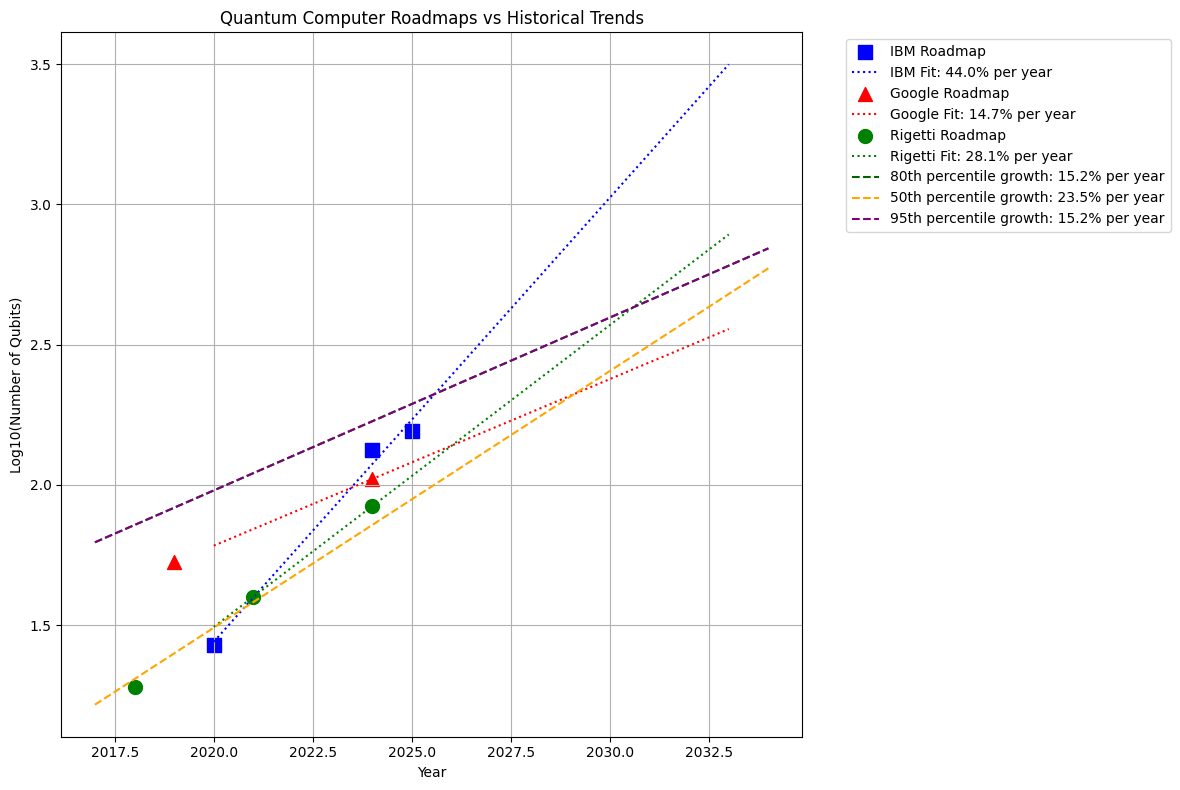


Projected number of qubits in 2030:
80th percentile projection: 395
50th percentile projection: 255


In [47]:
# Define roadmap data points
roadmaps = {
    'IBM': {
        'data': [(2020, 27), (2024, 133), (2025,156)],
        'color': 'blue',
        'marker': 's'
    },
    'Google': {
        'data': [(2019, 53), (2024, 105)],
        'color': 'red', 
        'marker': '^'
    },
    'Rigetti': {
        'data': [(2018, 19), (2021, 40), (2024, 84)],
        'color': 'green',
        'marker': 'o'
    }
}
# Create figure
plt.figure(figsize=(12, 8))

# Plot roadmap points and fit lines for each company
for company, roadmap_info in roadmaps.items():
    years, qubits = zip(*roadmap_info['data'])
    
    # Plot scatter points
    plt.scatter(years, np.log10(qubits),
               label=f'{company} Roadmap',
               color=roadmap_info['color'],
               marker=roadmap_info['marker'],
               s=100)
    
    # Fit line to roadmap points
    z = np.polyfit(years, np.log10(qubits), 1)
    p = np.poly1d(z)
    
    # Calculate growth rate
    company_growth_rate = (10**z[0] - 1) * 100
    
    # Generate points for the fit line
    x_company_fit = np.linspace(2020, 2033, 100)
    y_company_fit = p(x_company_fit)
    
    # Plot fit line
    plt.plot(x_company_fit, y_company_fit, 
             color=roadmap_info['color'],
             linestyle=':',
             label=f'{company} Fit: {company_growth_rate:.1f}% per year')

# Plot the quantile regression lines
plt.plot(x_fit, y_quantile_fit_80, color='darkgreen', linestyle='--',
         label=f'80th percentile growth: {growth_rate_80:.1f}% per year')
plt.plot(x_fit, y_quantile_fit_50, color='orange', linestyle='--',
         label=f'50th percentile growth: {growth_rate_50:.1f}% per year')
#95 quartile regression line 
plt.plot(x_fit, y_quantile_fit_95, color='purple', linestyle='--',
         label=f'95th percentile growth: {growth_rate_95:.1f}% per year')

plt.xlabel('Year')
plt.ylabel('Log10(Number of Qubits)')
plt.title('Quantum Computer Roadmaps vs Historical Trends')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("Figures/roadmap_comparison.png")
plt.show()

# Print projected values for 2030
print("\nProjected number of qubits in 2030:")
print(f"80th percentile projection: {10**(slope_q80*2030 + intercept_q80):.0f}")
print(f"50th percentile projection: {10**(slope_q50*2030 + intercept_q50):.0f}")


# Roadmap Graph For Presentation

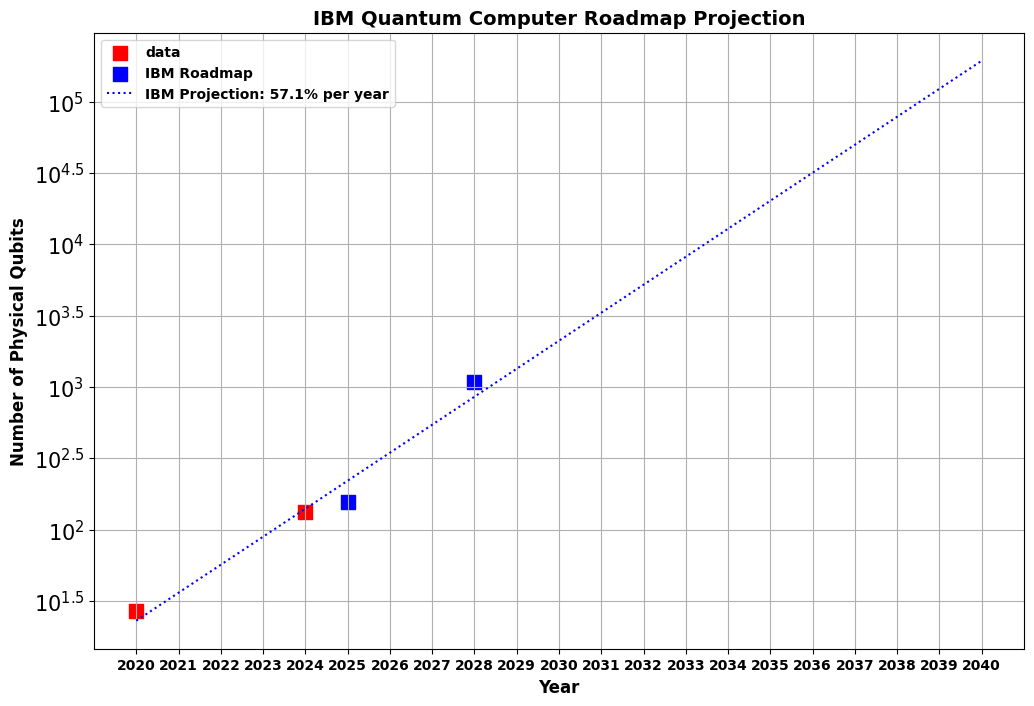

In [48]:
roadmaps = {
    'IBM': {
        'data': [(2020, 27), (2024, 133), (2025, 156), (2028, 1092)],
        'color': 'blue',
        'marker': 's'
    },
    'Google': {
        'data': [(2019, 54), (2023, 100), (2025, 1000)],
        'color': 'red', 
        'marker': '^'
    },
    'Rigetti': {
        'data': [(2023, 336), (2025, 1000), (2027, 4000)],
        'color': 'green',
        'marker': 'o'
    }
}


# Create figure
plt.figure(figsize=(12, 8))

# Plot actual IBM roadmap points
years, qubits = zip(*roadmaps['IBM']['data'])

# Separate data points before 2025 and after/equal to 2025
pre_2025_years = [y for y in years if y < 2025]
pre_2025_qubits = [qubits[i] for i, y in enumerate(years) if y < 2025]
post_2025_years = [y for y in years if y >= 2025]
post_2025_qubits = [qubits[i] for i, y in enumerate(years) if y >= 2025]

# Plot scatter points for IBM - pre 2025 in red
plt.scatter(pre_2025_years, np.log10(pre_2025_qubits),
           label='data',
           color='red',
           marker=roadmaps['IBM']['marker'],
           s=100)

# Plot scatter points for IBM - post 2025 in blue
if post_2025_years:
    plt.scatter(post_2025_years, np.log10(post_2025_qubits),
               label='IBM Roadmap',
               color=roadmaps['IBM']['color'],
               marker=roadmaps['IBM']['marker'],
               s=100)

# Fit line to roadmap points
z = np.polyfit(years, np.log10(qubits), 1)
p = np.poly1d(z)

# Calculate growth rate
ibm_growth_rate = (10**z[0] - 1) * 100

# Generate points for the fit line
x_company_fit = np.linspace(min(years), 2040, 100)
y_company_fit = p(x_company_fit)

# Plot fit line
plt.plot(x_company_fit, y_company_fit, 
         color=roadmaps['IBM']['color'],
         linestyle=':',
         label=f'IBM Projection: {ibm_growth_rate:.1f}% per year')

# Add labels and title with darker and bolder styling
plt.xlabel('Year', fontweight='bold', color='black', fontsize=12)
plt.ylabel('Number of Physical Qubits', fontweight='bold', color='black', fontsize=12)
plt.title('IBM Quantum Computer Roadmap Projection', fontweight='bold', fontsize=14)
plt.legend(prop={'weight':'bold', 'size':10})
plt.grid(True)

# Make tick labels darker and bolder
plt.xticks(range(2020, 2041, 1), fontweight='bold', color='black')
plt.yticks(fontweight='bold', color='black', fontsize=15)

# Set y-axis to use scientific notation (10^x format)
from matplotlib.ticker import ScalarFormatter, LogFormatter, FuncFormatter

def log_tick_formatter(val, pos=None):
    return f'$10^{{{int(val)}}}$' if val == int(val) else f'$10^{{{val:.1f}}}$'

plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.show()

# Gate Times Over Time

In [49]:
# extracting data for erorr rate in dataframe

import pandas as pd
from io import StringIO
qpu_metrics

superconducting_qubits = qpu_metrics[qpu_metrics['Modality'] == 'Superconducting']
superconducting_qubits = superconducting_qubits[superconducting_qubits["Commercially available?"] != "Future Plan"]
superconducting_qubits.dropna(subset=["2-Gate Fidelity (Median/Avg)", 'w'], inplace=True)
superconducting_qubits['Fidelity'] = superconducting_qubits['2-Gate Fidelity (Median/Avg)']
superconducting_qubits['Year'] = superconducting_qubits['w']
df = superconducting_qubits[["Year", "Fidelity"]]


In [54]:
superconducting_qubits.columns

Index(['Sources', 'Confirmed by manufacturer?', 'Comments', 'Name sent',
       'Status', 'Latest Status Date', 'ID', 'Company', 'QPU Name / Chipset',
       'Company & Name', 'Model/Instance', 'w', 'Country HQ', 'Accessible Via',
       'Commercially available?', 'Compatible SDKs', 'Modality',
       'Analog or Gate-based', 'Qubits/ Qumodes', 'Tunable couplers',
       'Atoms / Modality details', 'Layout', 'Connectivity avg',
       'Native gates', '2-Gate Fidelity (Median/Avg)', '2-Gate Fidelity (log)',
       '2-Gate Fidelity (ISWAP)', '2-Gate Fidelity (XY)',
       '2-Gate Fidelity (CZ)', '3-Gate Fidelity (Toffoli)',
       'Bell-State fidelity', 'GHZ n-qubit fidelity', '1-Gate-Fidelity',
       '1-Gate-Fidelity (log)', 'Readout fidelity',
       'SPAM (state preparation and measurement error)',
       'Memory Error per Qubit at average depth level', 'Amplitude Fidelity',
       'Crosstalk error', 'T1 (μs)', 'T2 (μs)', '1Q Gate Time (ns)',
       '2Q Gate Time (ns)', '1Q Gate Time 

In [70]:
import statsmodels.formula.api as smf


# # ==========================================================
# # 1. Input Data
# # ==========================================================
# year_gate_time = [
#     (2024, 35),
#     (2022, 594),
#     (2022, 660),
#     (2022, 586),
#     (2022, 660),
#     (2022, 685),
#     (2023, 68),
#     (2022, 561),
#     (2024, 68),
#     (2024, 48),
#     (2023, 100),
#     (2021, 400),
#     (2023, 400),
#     (2020, 40),
#     (2023, 72),
#     (2023, 96),
#     (2023, 72),
#     (2024, 108),
#     (2022, 218),
#     (2022, 188),
#     (2017, 169),
#     (2017, 213),
#     (2022, 70),
# ]

# # ==========================================================
# # 2. Prepare Arrays
# # ==========================================================
# years = np.array([x[0] for x in year_gate_time])
# gate_times = np.array([x[1] for x in year_gate_time])

# # Log-transform the gate times (base 10)
# log10_gate_times = np.log10(gate_times)


#read dataframe into numpy array
csvfile = 'Datasets/QPUmetrics.csv'
# qpu_metrics = pd.read_csv(csvfile)
#forget the first row
qpu_metrics = pd.read_csv(csvfile, skiprows=1)
superconducting_qubits = qpu_metrics[qpu_metrics['Modality'] == 'Superconducting']
superconducting_qubits = superconducting_qubits[superconducting_qubits["Commercially available?"] != "Future Plan"]
df_gate = superconducting_qubits.dropna(subset=['w', '2Q Gate Time (ns)'])

# Clean gate time data by removing non-numeric entries
df_gate = df_gate[pd.to_numeric(df_gate['2Q Gate Time (ns)'], errors='coerce').notna()]

years = df_gate['w'].astype(float)  # Convert to float
gate_times = df_gate['2Q Gate Time (ns)'].astype(float)  # Convert to float
log10_gate_times = np.log10(gate_times)



# ==========================================================
# 3. Linear Regression in log-space WITH Covariance
#    to get standard errors
# ==========================================================
coeffs, cov = np.polyfit(years, log10_gate_times, 1, cov=True)
slope, intercept = coeffs
slope_err = np.sqrt(cov[0, 0])
intercept_err = np.sqrt(cov[1, 1])

# Convert slope to "yearly factor"
#   log10(gate_time) = slope*year + intercept
# => gate_time = 10^(slope*year + intercept) = 10^intercept * 10^(slope*year)
#
# The fraction by which gate_time changes per year is 10^slope.
# => yearly percent DECREASE = (1 - 10^slope)*100

yearly_factor = 10**slope  # multiply factor each year
# Propagate uncertainty:
#   derivative wrt slope = d(10^slope)/d(slope) = ln(10)*10^slope
yearly_factor_err = np.log(10) * 10**slope * slope_err

percent_decrease = (1 - yearly_factor) * 100
percent_decrease_err = yearly_factor_err * 100

print("=== Linear Regression in Log-Space ===")
print(f"Fitted slope (log10 space): {slope:.4f} ± {slope_err:.4f}")
print(f"Fitted intercept (log10 space): {intercept:.4f} ± {intercept_err:.4f}")
print(f"Yearly factor = 10^slope = {yearly_factor:.3f} ± {yearly_factor_err:.3f}")
print(f"Yearly percent decrease = (1 - {yearly_factor:.3f}) * 100 = "
      f"{percent_decrease:.2f}% ± {percent_decrease_err:.2f}%")

# Build a polynomial model for plotting (linear fit in log-space)
linear_fit = np.poly1d(coeffs)

# ==========================================================
# 4. Quantile Regression (20th Percentile)
#    and standard error of the slope
# ==========================================================
df = pd.DataFrame(year_gate_time, columns=["year", "gate_time"])
df["log10_gate_time"] = np.log10(df["gate_time"])

quantile = 0.2
model = smf.quantreg("log10_gate_time ~ year", df)
res = model.fit(q=quantile)

slope_q = res.params["year"]
intercept_q = res.params["Intercept"]
slope_q_err = res.bse["year"]
intercept_q_err = res.bse["Intercept"]

# Convert slope to "yearly factor" and find percent decrease
yearly_factor_q = 10**slope_q
yearly_factor_q_err = np.log(10) * 10**slope_q * slope_q_err

percent_decrease_q = (1 - yearly_factor_q) * 100
percent_decrease_q_err = yearly_factor_q_err * 100

print("\n=== 20th Percentile Quantile Regression ===")
print(res.summary())
print(f"Quantile slope (log10 space): {slope_q:.4f} ± {slope_q_err:.4f}")
print(f"Quantile intercept (log10 space): {intercept_q:.4f} ± {intercept_q_err:.4f}")
print(f"Yearly factor = 10^slope_q = {yearly_factor_q:.3f} ± {yearly_factor_q_err:.3f}")
print(f"Yearly percent decrease (quantile) = (1 - {yearly_factor_q:.3f}) * 100 = "
      f"{percent_decrease_q:.2f}% ± {percent_decrease_q_err:.2f}%")


=== Linear Regression in Log-Space ===
Fitted slope (log10 space): -0.0422 ± 0.0514
Fitted intercept (log10 space): 87.5357 ± 103.9068
Yearly factor = 10^slope = 0.907 ± 0.107
Yearly percent decrease = (1 - 0.907) * 100 = 9.25% ± 10.74%

=== 20th Percentile Quantile Regression ===
                         QuantReg Regression Results                          
Dep. Variable:        log10_gate_time   Pseudo R-squared:              0.06955
Model:                       QuantReg   Bandwidth:                         nan
Method:                 Least Squares   Sparsity:                          nan
Date:                Wed, 21 May 2025   No. Observations:                   23
Time:                        13:02:52   Df Residuals:                       21
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interce

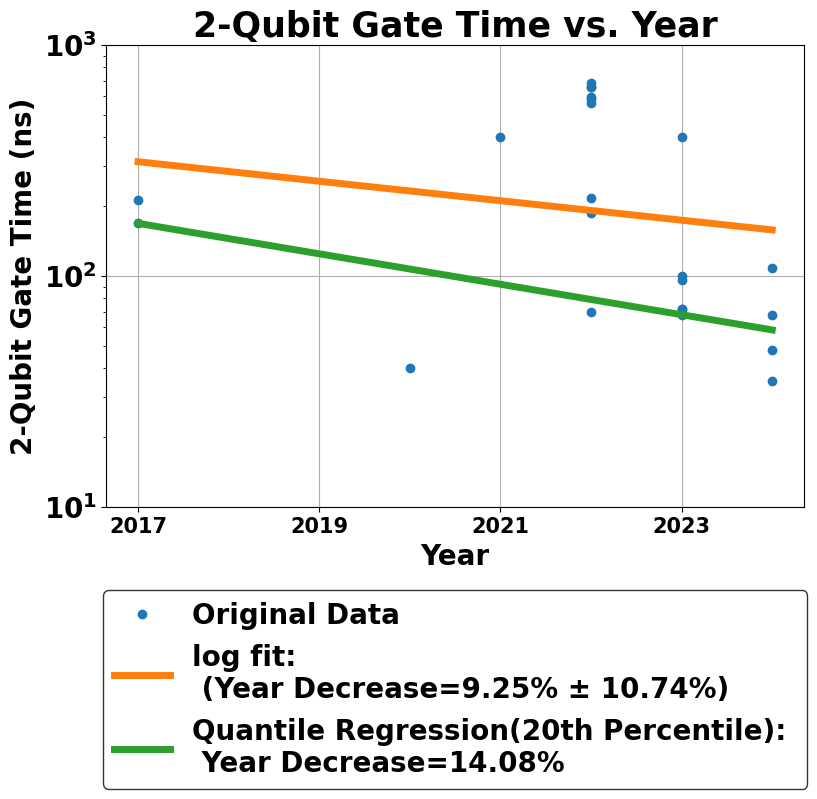

In [71]:

# ==========================================================
# 5. Plot Results
# ==========================================================
# plt.figure(figsize=(10,10))
# plt.figure(figsize=(15, 8))
plt.figure(figsize=(9, 6))

# Original data
plt.plot(df["year"], df["gate_time"], "o", label="Original Data")

# Continuous x-range for smooth lines
years_smooth = np.linspace(min(df["year"]), max(df["year"]), 100)

# -- Linear Regression Fit --
fitted_log10_gate_times = linear_fit(years_smooth)
fitted_gate_times = 10**fitted_log10_gate_times
plt.plot(
    years_smooth,
    fitted_gate_times,
    "-",
    label=(
        "log fit: \n "
        f"(Year Decrease={(1 - 10**slope):.2%} ± {percent_decrease_err:.2f}%)"
    ),
    linewidth=5,
)

# -- Quantile Regression Fit --
fitted_quantile_log10_gate_times = res.predict(pd.DataFrame({"year": years_smooth}))
fitted_quantile_gate_times = 10**fitted_quantile_log10_gate_times


plt.plot(
    years_smooth,
    fitted_quantile_gate_times,
    "-",
    label=(
        f"Quantile Regression(20th Percentile): \n Year Decrease={(1 - 10**slope_q):.2%} "
    ),
    linewidth=5,
)

# Log scale on the y-axis
plt.yscale("log")
plt.xlabel("Year", fontweight='bold', fontsize=20)
plt.ylabel("2-Qubit Gate Time (ns)", fontweight='bold', fontsize=20)

font_properties = FontProperties()
font_properties.set_size(20)
font_properties.set_weight('bold')
#old legend format
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=20, frameon=True, shadow=True, facecolor='white', edgecolor='black', fancybox=True, prop=font_properties)

# plt.legend(bbox_to_anchor=(0.5, -0.35), loc="upper center", fontsize=20, frameon=True, shadow=True, facecolor='white', edgecolor='black', fancybox=True, prop=font_properties)

plt.legend(fontsize=20,
          loc='upper center',
          bbox_to_anchor=(0.5, -0.15), 
          frameon=True,  # Adds a frame around the legend
          facecolor='white',  # White background
          edgecolor='black', prop=font_properties)  # Black border

plt.yticks(fontsize=20, fontweight="bold")
plt.ylim(10, 1000)
plt.xticks(np.arange(2017, 2025, 2), fontsize=15, fontweight="bold")
plt.grid(True)
plt.grid(True)
# plt.tight_layout()
plt.title("2-Qubit Gate Time vs. Year", fontsize=25, fontweight='bold')
plt.savefig("Figures/2-qubit-gate-time-vs-year.png", dpi=300, bbox_inches='tight')
plt.show()


# Gate Error Rate

In [58]:

# If desired, you can strip any extra whitespace:
df["Year"] = df["Year"].astype(str).str.strip()
# df["Technology"] = df["Technology"].astype(str).str.strip()
df["Fidelity"] = df["Fidelity"].astype(str).str.strip()

# Optionally, remove '%' from Fidelity and convert to float:
df["Fidelity"] = (
    df["Fidelity"]
    .str.replace("%", "", regex=False)    # remove % sign
    .replace("", None)                    # empty strings to None
    .astype(float)                        # convert to float (NaN if missing)
)

print(df)
# analyse the dataframe
cleaned_df = df.dropna(subset=["Fidelity", "Year"])

#drop anything with year after 2024
cleaned_df = cleaned_df[cleaned_df["Year"].astype(str).str.isnumeric()]
cleaned_df["Year"] = cleaned_df["Year"].astype(int)
cleaned_df = cleaned_df[cleaned_df["Year"] <= 2024]

KeyError: 'Year'

In [59]:

import statsmodels.formula.api as smf


plt.figure(figsize=(9, 6))
# Filter the dataframe for superconducting technology
# superconducting_df = cleaned_df[cleaned_df["Technology"] == "Superconducting"]
superconducting_df = cleaned_df
superconducting_df = superconducting_df[superconducting_df["Fidelity"].notnull()]

# Calculate the error rate
superconducting_df["Error_Rate"] = 1 - .01 * superconducting_df["Fidelity"]
superconducting_df["Log_Error_Rate"] = np.log10(superconducting_df["Error_Rate"])



# Calculate years since 2017
superconducting_df["Years_since_2017"] = superconducting_df["Year"] - 2017

# Fit a line to the log error rate
# coefficients = np.polyfit(superconducting_df["Years_since_2017"], superconducting_df["Log Error Rate"], 1)

coefficients, cov = np.polyfit(
    superconducting_df["Years_since_2017"], 
    superconducting_df["Log_Error_Rate"], 
    1, 
    cov=True
)
slope, intercept = coefficients
slope_err = np.sqrt(cov[0, 0])  # standard error of the slope
intercept_err = np.sqrt(cov[1, 1])  # standard error of the intercept
print(f"Slope: {slope:.4f} ± {slope_err:.4f}")
print(f"Intercept: {intercept:.4f} ± {intercept_err:.4f}")


# Convert slope to decimal fraction for the "multiply factor" each year
yearly_factor = 10**slope  # < 1 if error is decreasing; > 1 if error is increasing
percent_decrease = (1 - yearly_factor) * 100  # in %

# Propagate uncertainty
# df/dm = -ln(10) * 10^m  --> absolute value for the magnitude
deriv = np.log(10) * 10**slope
percent_decrease_err = deriv * slope_err * 100  # in %

print(
    f"Yearly percent decrease = {percent_decrease:.2f}% "
    f"± {percent_decrease_err:.2f}%"
)



# Print the fit parameters
slope, intercept = coefficients
print(f"Slope exponentiated: {10**slope}")
print(f"Intercept: {intercept}")


linear_fit = np.poly1d(coefficients)
years_since_2017 = np.linspace(min(superconducting_df["Years_since_2017"]), max(superconducting_df["Years_since_2017"]), 100)
fitted_log_error_rate = linear_fit(years_since_2017)

# plt.title("2-Qubit Error Rate of Superconducting Qubits vs. Year", fontsize=20, fontweight="bold")
# plt.legend(fontsize=20, loc='upper left', bbox_to_anchor=(1, 1))




# Perform quantile regression for the 20th percentile on the log-transformed error rates
quantile = 0.2
model = smf.quantreg('Log_Error_Rate ~ Years_since_2017', superconducting_df)
res = model.fit(q=quantile)

# Print the quantile regression results
print(res.summary())

# Generate fitted values for a smooth line
years_smooth = np.linspace(min(superconducting_df['Years_since_2017']), max(superconducting_df['Years_since_2017']), 100)
fitted_quantile_log_error_rate = res.predict(pd.DataFrame({'Years_since_2017': years_smooth}))
fitted_quantile_error_rate = 10**fitted_quantile_log_error_rate

# Plot the continuous fit line for the quantile regression
plt.plot(
    years_smooth + 2017,
    fitted_quantile_error_rate,
    "-",
    label=f"Quantile Regression (20th Percentile):\n Year Decrease={(1-10**res.params['Years_since_2017']):.2%}",
    color='green',  # Make the line color green
    linewidth=5  # Increase the line width
)

# Plot the year vs error rate
plt.plot(superconducting_df["Year"], 
         superconducting_df["Error_Rate"], 
         "o",
         label="Error_Rate_Data")
plt.yscale("log")

plt.plot(superconducting_df["Year"], 
         10**linear_fit(superconducting_df["Years_since_2017"]), 
         "-", 
         label=f"log fit: \n Year Decrease={(1-10**coefficients[0]):.2%} ± {percent_decrease_err:.2f}%",
         color='orange',  # Make the line color black
         linewidth=5)  # Increase the line width
plt.xlabel("Year", fontsize=20, fontweight="bold")
plt.ylabel("2-Qubit Gate Error Rate", fontsize=20, fontweight="bold")

font_properties = FontProperties()
font_properties.set_size(20)
font_properties.set_weight('bold')
#old legend format
# plt.legend(fontsize=20, 
#           loc='upper left', 
#           bbox_to_anchor=(1, 1),
#           frameon=True,  # Adds a frame around the legend
#           facecolor='white',  # White background
#           edgecolor='black', prop=font_properties)  # Black border
plt.legend(fontsize=20,
          loc='upper center',
          bbox_to_anchor=(0.5, -0.15), 
          frameon=True,  # Adds a frame around the legend
          facecolor='white',  # White background
          edgecolor='black', prop=font_properties)  # Black border
plt.yticks(fontsize=20, fontweight="bold")
plt.xticks(np.arange(2017, 2025, 2), fontsize=15, fontweight="bold")
plt.grid(True)

plt.title("2-Qubit Gate Error Rate vs. Year", fontsize=25, fontweight='bold')
plt.savefig("Figures/2-qubit-gate-error-vs-year.png", dpi=300, bbox_inches='tight')



NameError: name 'cleaned_df' is not defined

<Figure size 900x600 with 0 Axes>

# With Error Correction Overhead

In [ ]:
# Filter and analyze the logical to physical qubit ratio using the surface code formula
import math

def surface_code_formula(pP: float) -> float:
    pL = 1e-18  # Target logical error rate
    pth = 1e-2  # Threshold error rate
    numerator = 4 * math.log(math.sqrt(10 * pP / pL))
    denominator = math.log(pth / pP)
    fraction = numerator / denominator
    return (fraction + 1) ** 2  # Return logical to physical ratio directly

# # Filter the dataframe for superconducting technology and error rates < 0.5%
# superconducting_df = cleaned_df[cleaned_df["Technology"] == "Superconducting"]
superconducting_df = superconducting_df[superconducting_df["Fidelity"].notnull()]
superconducting_df["Error_Rate"] = 1 - .01 * superconducting_df["Fidelity"]
superconducting_df = superconducting_df[superconducting_df["Error_Rate"] < 0.005]  # Filter for < 0.5% error

# Calculate logical to physical ratio for each point
superconducting_df["Logical_to_Physical_Ratio"] = superconducting_df["Error_Rate"].apply(surface_code_formula)
superconducting_df["Log_Ratio"] = np.log10(superconducting_df["Logical_to_Physical_Ratio"])
superconducting_df["Years_since_2017"] = superconducting_df["Year"] - 2017

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(superconducting_df["Year"], 
         superconducting_df["Logical_to_Physical_Ratio"], 
         "o",
         label="Data Points")
plt.yscale("log")

# Fit a line to the log ratio
coefficients, cov = np.polyfit(
    superconducting_df["Years_since_2017"], 
    superconducting_df["Log_Ratio"], 
    1, 
    cov=True
)
slope, intercept = coefficients
slope_err = np.sqrt(cov[0, 0])
intercept_err = np.sqrt(cov[1, 1])

# Calculate and print statistics
yearly_factor = 10**slope
percent_change = (yearly_factor - 1) * 100
deriv = np.log(10) * 10**slope
percent_change_err = deriv * slope_err * 100

print(f"Slope: {slope:.4f} ± {slope_err:.4f}")
print(f"Yearly percent change in ratio = {percent_change:.2f}% ± {percent_change_err:.2f}%")

# Plot the fit line
years_since_2017 = np.linspace(min(superconducting_df["Years_since_2017"]), 
                              max(superconducting_df["Years_since_2017"]), 100)
linear_fit = np.poly1d(coefficients)
plt.plot(years_since_2017 + 2017, 
         10**linear_fit(years_since_2017), 
         "-", 
         label=f"Log fit:\nYearly Change={percent_change:.1f}% ± {percent_change_err:.1f}%",
         color='orange',
         linewidth=5)

# Perform quantile regression
quantile = 0.2
model = smf.quantreg('Log_Ratio ~ Years_since_2017', superconducting_df)
res = model.fit(q=quantile)

# Generate and plot quantile regression line
years_smooth = np.linspace(min(superconducting_df['Years_since_2017']), 
                          max(superconducting_df['Years_since_2017']), 100)
fitted_quantile_log_ratio = res.predict(pd.DataFrame({'Years_since_2017': years_smooth}))
fitted_quantile_ratio = 10**fitted_quantile_log_ratio

plt.plot(
    years_smooth + 2017,
    fitted_quantile_ratio,
    "-",
    label=f"Quantile Regression (20th Percentile):\nYearly Change={(10**res.params['Years_since_2017']-1):.1%}",
    color='green',
    linewidth=5
)

# Formatting
plt.xlabel("Year", fontsize=20, fontweight="bold")
plt.ylabel("Logical to Physical Qubit Ratio", fontsize=20, fontweight="bold")
plt.yticks(fontsize=20, fontweight="bold")
plt.xticks(np.arange(2017, 2025, 2), fontsize=15, fontweight="bold")
plt.grid(True)

font_properties = FontProperties()
font_properties.set_size(20)
font_properties.set_weight('bold')
plt.legend(fontsize=20,
          loc='upper left',
          bbox_to_anchor=(1, 1),
          frameon=True,
          facecolor='white',
          edgecolor='black',
          prop=font_properties)


In [ ]:

# Filter the dataframe for ion trap technology
ion_trap_df = cleaned_df[cleaned_df["Technology"] == "Trapped Ions"]
ion_trap_df = ion_trap_df[ion_trap_df["Fidelity"].notnull()]

# Calculate the error rate
ion_trap_df["Error Rate"] = 1 - .01 * ion_trap_df["Fidelity"]
ion_trap_df["Log Error Rate"] = np.log10(ion_trap_df["Error Rate"])

# Plot the year vs error rate
plt.plot(ion_trap_df["Year"], 
         ion_trap_df["Error Rate"], 
         "o",
         label="Error Rate Data")
plt.yscale("log")

# Calculate years since 2017
ion_trap_df["Years_since_2017"] = ion_trap_df["Year"] - 2017

# Fit a line to the log error rate
coefficients, cov = np.polyfit(
    ion_trap_df["Years_since_2017"], 
    ion_trap_df["Log Error Rate"], 
    1, 
    cov=True
)
slope, intercept = coefficients
slope_err = np.sqrt(cov[0, 0])  # standard error of the slope
intercept_err = np.sqrt(cov[1, 1])  # standard error of the intercept
print(f"Slope: {slope:.4f} ± {slope_err:.4f}")
print(f"Intercept: {intercept:.4f} ± {intercept_err:.4f}")

# Convert slope to decimal fraction for the "multiply factor" each year
yearly_factor = 10**slope  # < 1 if error is decreasing; > 1 if error is increasing
percent_decrease = (1 - yearly_factor) * 100  # in %

# Propagate uncertainty
deriv = np.log(10) * 10**slope
percent_decrease_err = deriv * slope_err * 100  # in %

print(
    f"Yearly percent decrease = {percent_decrease:.2f}% "
    f"± {percent_decrease_err:.2f}%"
)

linear_fit = np.poly1d(coefficients)
years_since_2017 = np.linspace(min(ion_trap_df["Years_since_2017"]), max(ion_trap_df["Years_since_2017"]), 100)
fitted_log_error_rate = linear_fit(years_since_2017)
plt.plot(ion_trap_df["Year"], 
         10**linear_fit(ion_trap_df["Years_since_2017"]), 
         "-", 
         label=f"log fit: Year Decrease={(1-10**coefficients[0]):.2%} ± {percent_decrease_err:.2f}%")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("2-Qubit Error Rate of Trapped Ion Qubits vs. Year")
plt.grid(True)
plt.legend()

# Print the fit parameters
slope, intercept = coefficients
print(f"Slope exponentiated: {10**slope}")
print(f"Intercept: {intercept}")



In [12]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit

# # Provided data
# data = {
#     "Year": [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
#     "Superconducting_2Gate": [
#         0.9598,
#         0.994,
#         0.986,
#         0.98,
#         0.9466,
#         0.9972,
#         0.996921,
#         0.997039,
#     ],
#     "Superconducting_1Gate": [
#         0.999,
#         0.9981,
#         0.9988,
#         0.999,
#         0.9991,
#         0.999783,
#         0.999684,
#         0.9992,
#     ],
#     "TrappedIons_2Gate": [None, None, 0.973, 0.995, 0.9977, 0.997, 0.99914, 0.9997],
#     "TrappedIons_1Gate": [
#         None,
#         None,
#         0.996,
#         0.9997,
#         0.99996,
#         0.9998,
#         0.999979,
#         0.999992,
#     ],
# }
# # Convert to DataFrame
# df = pd.DataFrame(data)

# # Calculate 1 - Fidelity values
# df["Superconducting_2Gate"] = 1 - df["Superconducting_2Gate"]
# df["Superconducting_1Gate"] = 1 - df["Superconducting_1Gate"]
# df["TrappedIons_2Gate"] = 1 - df["TrappedIons_2Gate"]
# df["TrappedIons_1Gate"] = 1 - df["TrappedIons_1Gate"]

# # Define years for the x-axis
# years = df["Year"]
# # Define "years since 2017" for the x-axis
# df["Years_since_2017"] = df["Year"] - 2017
# years_since_2017 = df["Years_since_2017"]

# # Log transformation and removing NaN values
# df["log_Superconducting_2Gate"] = np.log10(df["Superconducting_2Gate"])
# df["log_Superconducting_1Gate"] = np.log10(df["Superconducting_1Gate"])
# df["log_TrappedIons_2Gate"] = np.log10(df["TrappedIons_2Gate"])
# df["log_TrappedIons_1Gate"] = np.log10(df["TrappedIons_1Gate"])

# # Removing rows with NaN for each category
# df_clean_super_2g = df.dropna(subset=["log_Superconducting_2Gate"])
# df_clean_super_1g = df.dropna(subset=["log_Superconducting_1Gate"])
# df_clean_ions_2g = df.dropna(subset=["log_TrappedIons_2Gate"])
# df_clean_ions_1g = df.dropna(subset=["log_TrappedIons_1Gate"])

# # Include logical to physical qubit ratio
# pl = 1e-18  # Define pl before using it
# scaling_factor_future = (
#     lambda fidelity: 2 * (4 * np.log(10 * pl) / np.log(100 * fidelity) - 1) ** 2 - 1
# )
# df["scaling_factor_future"] = np.log10(
#     scaling_factor_future(df["Superconducting_2Gate"])
# )
# df_clean_scaling = df.dropna(subset=["scaling_factor_future"])

# df["scaling_factor_iontrap"] = np.log10(scaling_factor_future(df["TrappedIons_2Gate"]))
# df_clean_scaling_iontrap = df.dropna(subset=["scaling_factor_iontrap"])


# # Linear fit for each category
# def linear_func(x, m, c):
#     return m * x + c


# # Fitting for Superconducting 2Gate
# popt_super_2g, _ = curve_fit(
#     linear_func,
#     df_clean_super_2g["Years_since_2017"],
#     df_clean_super_2g["log_Superconducting_2Gate"],
# )

# # Fitting for Superconducting 1Gate
# popt_super_1g, _ = curve_fit(
#     linear_func,
#     df_clean_super_1g["Years_since_2017"],
#     df_clean_super_1g["log_Superconducting_1Gate"],
# )

# # Fitting for TrappedIons 2Gate
# popt_ions_2g, _ = curve_fit(
#     linear_func,
#     df_clean_ions_2g["Years_since_2017"],
#     df_clean_ions_2g["log_TrappedIons_2Gate"],
# )

# # Fitting for TrappedIons 1Gate
# popt_ions_1g, _ = curve_fit(
#     linear_func,
#     df_clean_ions_1g["Years_since_2017"],
#     df_clean_ions_1g["log_TrappedIons_1Gate"],
# )

# # Fit logical to physical for superconducting
# popt_scaling, _ = curve_fit(
#     linear_func,
#     df_clean_scaling["Years_since_2017"],
#     df_clean_scaling["scaling_factor_future"],
# )

# pop_scaling_iontrap, _ = curve_fit(
#     linear_func,
#     df_clean_scaling_iontrap["Years_since_2017"],
#     df_clean_scaling_iontrap["scaling_factor_iontrap"],
# )

# # Plotting the results
# plt.figure(figsize=(10, 6))

# # Exponentiating the parameters to the power of 10
# exp_popt_super_2g = 10 ** np.array(popt_super_2g)
# exp_popt_super_1g = 10 ** np.array(popt_super_1g)
# exp_popt_ions_2g = 10 ** np.array(popt_ions_2g)
# exp_popt_ions_1g = 10 ** np.array(popt_ions_1g)


# # Plot for Superconducting 2Gate
# plt.scatter(
#     df_clean_super_2g["Year"],
#     df_clean_super_2g["log_Superconducting_2Gate"],
#     label="Superconducting 2Gate (data)",
#     color="blue",
# )
# plt.plot(
#     df_clean_super_2g["Year"],
#     linear_func(df_clean_super_2g["Years_since_2017"], *popt_super_2g),
#     label=f"Superconducting 2Gate (fit): year percentage decrease={(1- exp_popt_super_2g[0]):.1%}",
#     color="blue",
# )
# # percentage_decrease={(1- exp_popt_super_2g[0]):.2%}

# # Plot for Superconducting 1Gate
# # plt.scatter(
# #     df_clean_super_1g["Year"],
# #     df_clean_super_1g["log_Superconducting_1Gate"],
# #     label="Superconducting 1Gate (data)",
# #     color="green",
# # )
# # plt.plot(
# #     df_clean_super_1g["Year"],
# #     linear_func(df_clean_super_1g["Years_since_2017"], *popt_super_1g),
# #     label=f"Superconducting 1Gate (fit): m={exp_popt_super_1g[0]:.2}, c={exp_popt_super_1g[1]:.2}",
# #     color="green",
# # )

# # Plot for TrappedIons 2Gate
# plt.scatter(
#     df_clean_ions_2g["Year"],
#     df_clean_ions_2g["log_TrappedIons_2Gate"],
#     label="TrappedIons 2Gate (data)",
#     color="red",
# )
# plt.plot(
#     df_clean_ions_2g["Year"],
#     linear_func(df_clean_ions_2g["Years_since_2017"], *popt_ions_2g),
#     label=f"TrappedIons 2Gate (fit): year percentage decrease={(1-exp_popt_ions_2g[0]):.1%}",
#     color="red",
# )

# # label=f"TrappedIons 2Gate (fit): m={exp_popt_ions_2g[0]:.2}, c={exp_popt_ions_2g[1]:.2}"

# # Plot for TrappedIons 1Gate
# # plt.scatter(
# #     df_clean_ions_1g["Year"],
# #     df_clean_ions_1g["log_TrappedIons_1Gate"],
# #     label="TrappedIons 1Gate (data)",
# #     color="orange",
# # )
# # plt.plot(
# #     df_clean_ions_1g["Year"],
# #     linear_func(df_clean_ions_1g["Years_since_2017"], *popt_ions_1g),
# #     label=f"TrappedIons 1Gate (fit): m={exp_popt_ions_1g[0]:.2}, c={exp_popt_ions_1g[1]:.2}",
# #     color="orange",
# # )

# # Plot logical to physical ratio fit
# # plt.scatter(df_clean_scaling["Year"], df_clean_scaling["scaling_factor_future"], label="Logical/Physical Ratio (data)", color="purple")
# # plt.plot(df_clean_scaling["Year"], linear_func(df_clean_scaling["Years_since_2017"], *popt_scaling), label=f"Logical/Physical Ratio (fit): m={popt_scaling[0]:.2e}, c={popt_scaling[1]:.2e}", color="purple")

# # Labels and title
# plt.xlabel("Year")
# plt.ylabel("log(Error rate)")
# plt.title("2-Qubit Gate Error Rate Over Time: Superconducting vs. Trapped Ions")
# plt.legend(fontsize=12)
# plt.grid(True)
# plt.show()


# # I want to print out the the fit intercept exponentiated for each group
# print(
#     f"Superconducting 2 gate fit intercep (initial error rate)t: {10**popt_super_2g[1]}"
# )
# print(f"TrappedIons 2 gate fit intercept (initial error rate): {10**popt_ions_2g[1]}")

# Mapping Out Physical Qubits Over Time

In [ ]:
# graph roadmaps



import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Roadmap data
IBM_roadmap = {
    2020: 27,
    2022: 127,
    2024: 133,
    2025: 156,
    2029: 200,
    2033: 2000,
}

Google_roadmap = {
    2019: 54,
    2023: 100,
    2025: 1000,
}

Rigetti_roadmap = {
    2023: 336,
    2025: 1000,
    2027: 4000,
}

best_system_roadmap = {
    2016:22,
    2018:48, 
    2018:72, 
    2021:126,
    2022:433,
    2023:1120,
}


# Define improved exponential function for fitting
def exp_func(x, a, b, c):
    """Exponential function of the form a * exp(b * (x - x0)) + c"""
    return a * np.exp(b * (x - 2019)) + c


# Function to fit and plot data
def fit_and_plot_roadmap(data_dict, label, color):
    years = np.array(list(data_dict.keys()))
    qubits = np.array(list(data_dict.values()))

    # Initial parameter guesses
    p0 = [min(qubits), 0.5, 0]

    # Fit with better bounds
    try:
        popt, _ = curve_fit(
            exp_func, years, qubits, p0=p0, bounds=([0, -2, -1000], [10000, 2, 1000])
        )
    except RuntimeError:
        print(f"Fitting failed for {label}")
        return None

    # Generate smooth curve for plotting
    # years_smooth = np.linspace(2019, max(years), 100)
    years_smooth = np.linspace(2019, 2033, 100)
    fit_smooth = exp_func(years_smooth, *popt)

    # Plot original data points
    plt.scatter(years, qubits, color=color, label=f"{label} Roadmap", zorder=5, s=100)

    # Plot fitted curve
    plt.plot(
        years_smooth,
        fit_smooth,
        "--",
        color=color,
        label=f"{label} Exponential Fit",
        alpha=0.9,
        linewidth=4,
    )

    return popt

# Create plot
# plt.figure(figsize=(12, 8))
#make figsize long horizontally
plt.figure(figsize=(15, 8))
# Fit and plot each company's data
fit_and_plot_roadmap(IBM_roadmap, "IBM", "blue")
fit_and_plot_roadmap(Google_roadmap, "Google", "red")
fit_and_plot_roadmap(Rigetti_roadmap, "Rigetti", "green")
# fit_and_plot_roadmap(best_system_roadmap, "Best System", "purple")

# Customize plot
plt.xlabel("Year", fontsize=30, fontweight='bold')
plt.ylabel("Number of Physical Qubits", fontsize=30, fontweight='bold')
# plt.title("Quantum Computing Roadmaps: Projected Number of Physical Qubits", fontsize=19, weight="bold")
plt.grid(True)


font_properties = FontProperties()
font_properties.set_size(25)
font_properties.set_weight('bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=25, frameon=True, shadow=True, facecolor='white', edgecolor='black', fancybox=True, prop=font_properties)
plt.ylim(0, 5000)

#make the legend larger and towards the right
# 

# Use logarithmic scale for y-axis since the growth is exponential


# Add minor gridlines
plt.grid(True, which="minor", alpha=0.9)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.xticks(fontsize=20, fontweight='bold')
plt.xticks(np.arange(2019, 2032, 5), fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
plt.show()

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Original roadmap data
IBM_roadmap = {
    2020: 27,
    2022: 127,
    2024: 133,
    2025: 156,
    2029: 200,
    2033: 2000,
}

Google_roadmap = {
    2019: 54,
    2023: 100,
    2025: 1000,
}

Rigetti_roadmap = {
    2023: 336,
    2025: 1000,
    2027: 4000,
}

# Constants
PHYSICAL_TO_LOGICAL_RATIO = 1000  # 10^3 physical qubits per logical qubit
MAX_PROBLEM_SIZE = 1e50  # Maximum problem size to consider


def exp_func(x, a, b, c):
    """Exponential function for fitting"""
    return a * np.exp(b * (x - 2019)) + c


def calculate_problem_size(physical_qubits):
    """Calculate problem size from physical qubits"""
    logical_qubits = physical_qubits / PHYSICAL_TO_LOGICAL_RATIO
    # Only calculate for positive logical qubits
    if logical_qubits <= 0:
        return 0
    # Cap the maximum problem size
    problem_size = 2**logical_qubits
    return min(problem_size, MAX_PROBLEM_SIZE)


def fit_and_extrapolate(data_dict, company_name, color):
    # Fit original data
    years = np.array(list(data_dict.keys()))
    qubits = np.array(list(data_dict.values()))

    try:
        popt, _ = curve_fit(
            exp_func,
            years,
            qubits,
            p0=[min(qubits), 0.5, 0],
            bounds=([0, -2, -1000], [10000, 2, 1000]),
        )
    except RuntimeError:
        print(f"Fitting failed for {company_name}")
        return None

    # Generate extrapolated years and corresponding qubit numbers
    years_extended = np.linspace(
        2019, 2050, 200
    )  # Increased number of points for smoother curve
    qubits_extended = exp_func(years_extended, *popt)

    # Calculate problem sizes
    problem_sizes = np.array([calculate_problem_size(q) for q in qubits_extended])

    # Only plot where problem size is > 0 and < MAX_PROBLEM_SIZE
    valid_mask = (problem_sizes > 0) & (problem_sizes < MAX_PROBLEM_SIZE)

    if np.any(valid_mask):
        plt.plot(
            years_extended[valid_mask],
            problem_sizes[valid_mask],
            "--",
            color=color,
            label=f"{company_name} Projected",
            alpha=0.99,
        )

        # Plot original data points converted to problem size
        original_problem_sizes = [calculate_problem_size(q) for q in qubits]
        valid_original = np.array(original_problem_sizes) < MAX_PROBLEM_SIZE
        plt.scatter(
            years[valid_original],
            np.array(original_problem_sizes)[valid_original],
            color=color,
            label=f"{company_name} Data",
        )

        # Add the year when MAX_PROBLEM_SIZE is reached
        # if np.any(problem_sizes >= MAX_PROBLEM_SIZE):
        #     year_max = years_extended[problem_sizes >= MAX_PROBLEM_SIZE][0]
        #     plt.annotate(f'{company_name}\nreaches max\nat {year_max:.1f}',
        #                 xy=(year_max, MAX_PROBLEM_SIZE),
        #                 xytext=(5, 5), textcoords='offset points',
        #                 fontsize=8, color=color)


# Create plot
plt.figure(figsize=(15, 10))  # Increased figure size for better visibility

# Fit and plot each company's data
fit_and_extrapolate(IBM_roadmap, "IBM", "blue")
fit_and_extrapolate(Google_roadmap, "Google", "red")
fit_and_extrapolate(Rigetti_roadmap, "Rigetti", "green")

# Customize plot
plt.xlabel("Year", fontsize=20)  # Enlarged x-axis label
plt.ylabel("Maximum Problem Size 2^(logical qubits)", fontsize=20)  # Enlarged y-axis label
plt.yticks(fontsize=15)  # Enlarged tick labels
plt.xticks(fontsize=15)  # Enlarged tick labels
plt.title(
    "Projected Maximum Problem Size Based on Quantum Computing Roadmaps* (2019-2050)",
    fontsize=20,
)
plt.grid(True)
plt.legend(fontsize=15)
plt.figtext(0.5, 0.0, "*Note: Assuming 1000 physical to logical ratio.", ha="center", fontsize=12)

# Use logarithmic scale for y-axis
plt.yscale("log")

# Add minor gridlines
plt.grid(True, which="minor", alpha=0.2)

# Set x-axis limits explicitly
plt.xlim(2019, 2050)

# Add blurb
blurb = (
    "This Graph Assumes that log(n) qubits are necessary for a problem size of size n.\n" 

)
plt.figtext(0.5, -0.1, blurb, wrap=True, horizontalalignment='center', fontsize=15)

# Adjust layout
plt.tight_layout()

plt.show()


In [15]:
# now lets look at sensitiv